In [1]:
from collections import Counter
import pandas as pd
import numpy as np
import random # random number/seed
import matplotlib.pyplot as plt
from IPython.core.pylabtools import figsize
import math
import sympy as sy # equation solver
import seaborn as sns # heatmap
import time # timestamp
import scipy.stats as stats

# Generate and plot a synthetic imbalanced classification dataset
# ML setup
from sklearn.datasets import make_classification
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import cross_validate
from sklearn.model_selection import RepeatedKFold
from sklearn.model_selection import train_test_split
from scipy.optimize import minimize

# ML models
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from sklearn.svm import SVC

# ML metrics and curves
import sklearn.metrics as metrics
from sklearn.metrics import confusion_matrix, brier_score_loss, log_loss
from sklearn.calibration import calibration_curve

#imputation and feature scaling
from sklearn.impute import KNNImputer
from sklearn.preprocessing import MinMaxScaler
from matplotlib.ticker import PercentFormatter

/Applications/Anaconda/anaconda3/lib/python3.7/site-packages/pandas/compat/_optional.py:138: UserWarning: Pandas requires version '2.7.0' or newer of 'numexpr' (version '2.6.9' currently installed).
  warnings.warn(msg, UserWarning)


### Custom Functions

In [2]:
def gnumeric_func(data, columns):
    data[columns] = data[columns].apply(lambda x: pd.factorize(x, sort=True)[0])
    return data

def treatNone(x, uFN, uTN):
    return x * uFN + (1-x) * uTN
def test(x, sensitivity, specificity, uTN, uTP, uFN, uFP, u):
    return x * sensitivity * uTP + x * (1-sensitivity) * uFN + (1-x) * (1-specificity) * uFP + (1-x) * specificity * uTN + u
def treatAll(x, uFP, uTP):
    return x * uTP + (1-x) * uFP

def pLpStarpUThresholds(s1, s2, uTN, uTP, uFN, uFP, u):
    """
    Returns the pL, pStar, and pU thresholds
    """
    x = sy.symbols('x')
    pU = sy.solve(treatAll(x, uFP, uTP) - test(x, s1, s2, uTN, uTP, uFN, uFP, u), x)
    pStar = sy.solve(treatAll(x, uFP, uTP) - treatNone(x, uFN, uTN), x)
    pL = sy.solve(treatNone(x, uFN, uTN) - test(x, s1, s2, uTN, uTP, uFN, uFP, u), x)
    pU = -999 if (len(pU) == 0) else float(pU[0])
    pU = 1 if (pU > 1) else pU
    pU = 0 if ((pU < 0) & (pU != -999)) else pU
    pStar = -999 if (len(pStar) == 0) else float(pStar[0])
    pStar = 1 if (pStar > 1) else pStar
    pStar = 0 if ((pStar < 0) & (pStar != -999)) else pStar
    pL = -999 if (len(pL) == 0) else float(pL[0])
    pL = 1 if (pL > 1) else pL
    pL = 0 if ((pL < 0) & (pL != -999)) else pL

    return [pL, pStar, pU]

def expectedGainUtil(s1, s2, uTN, uTP, uFN, uFP, u, graph):
    x = sy.symbols('x')
    pU = sy.solve(treatAll(x, uFP, uTP) - test(x, s1, s2, uTN, uTP, uFN, uFP, u), x)
    pStar = sy.solve(treatAll(x, uFP, uTP) - treatNone(x, uFN, uTN), x)
    pL = sy.solve(treatNone(x, uFN, uTN) - test(x, s1, s2, uTN, uTP, uFN, uFP, u), x)
    if(pStar > pU):
        result = 0
    else:
        result = sy.integrate(x * (test(x, s1, s2, uTN, uTP, uFN, uFP, u) - treatNone(x, uFN, uTN)), (x, pL, pStar)) + \
                sy.integrate(x * (test(x, s1, s2, uTN, uTP, uFN, uFP, u) - treatAll(x, uFP, uTP)), (x, pStar, pU))
    
    if(graph == True):
        X = np.array(range(2))
        plt.plot(X,treatNone(X, uFN, uTN), label = "Treat None")
        plt.plot(X,test(X, s1, s2, uTN, uTP, uFN, uFP, u), label = "Test")
        plt.plot(X,treatAll(X, uFP, uTP), label = "Treat All")     
        plt.legend(prop={'size':13}, loc='lower right')
        plt.show()

    pU = -999 if (len(pU) == 0) else float(pU[0])
    pU = 1 if (pU > 1) else pU
    pU = 0 if ((pU < 0) & (pU != -999)) else pU
    pStar = -999 if (len(pStar) == 0) else float(pStar[0])
    pStar = 1 if (pStar > 1) else pStar
    pStar = 0 if ((pStar < 0) & (pStar != -999)) else pStar
    pL = -999 if (len(pL) == 0) else float(pL[0])
    pL = 1 if (pL > 1) else pL
    pL = 0 if ((pL < 0) & (pL != -999)) else pL

    return [result, pL, pStar, pU]

def utilityGain(p, s1, s2, uTN, uTP, uFN, uFP, u, pL, pStar, pU):
#     areaUtility, pL, pStar, pU = expectedGainUtil(s1, s2, uTN, uTP, uFN, uFP, u, graph = False)
    if(p < pL):
        result = test(p, s1, s2, uTN, uTP, uFN, uFP, u) - treatNone(p, uFN, uTN)
    elif((p > pL) & (p < pStar)):
        result = test(p, s1, s2, uTN, uTP, uFN, uFP, u) - treatNone(p, uFN, uTN)
    elif((p > pStar) & (p < pU)):
        result = test(p, s1, s2, uTN, uTP, uFN, uFP, u) - treatAll(p, uFP, uTP)
    else:
        result = test(p, s1, s2, uTN, uTP, uFN, uFP, u) - treatAll(p, uFP, uTP)
    return result
    
def modelPriorsOverRoc(modelChosen, uTN, uTP, uFN, uFP, u):
    pLs = []
    pStars = []
    pUs = []
    #for each pair of tpr, fpr
    if(type(np.array(modelChosen['tpr'])) == list):
        tprArray = np.array(np.array(modelChosen['tpr'])[0])
        fprArray = np.array(np.array(modelChosen['fpr'])[0])
    else:
        tprArray = np.array(modelChosen['tpr'])
        fprArray = np.array(modelChosen['fpr'])
    if(tprArray.size > 1):
        for cutoffIndex in range(0, tprArray.size):
            tpr = tprArray[cutoffIndex]
            fpr = fprArray[cutoffIndex]
            pL, pStar, pU = pLpStarpUThresholds(tpr, 1 - fpr, uTN, uTP, uFN, uFP, u)
            pLs.append(pL)
            pStars.append(pStar)
            pUs.append(pU)
        return [pLs, pStars, pUs]
    else:
        return [[0], [0], [0]]
    
def priorFiller(priorList, lower: bool):
    """
    some priors are not defined. For those -999, change to 1 or 0 depending on pL or pU
    """
    if(lower == True):
        for index, item in enumerate(priorList):
            lenList = len(priorList)
            midPoint = lenList/2
            if((index < midPoint) & (lenList > 1)):
                if(item == -999):
                    priorList[index] = 1
            if((index > midPoint) & (lenList > 1)):
                if(item == -999):
                    priorList[index] = 0
    else:
        for index, item in enumerate(priorList):
            lenList = len(priorList)
            midPoint = lenList/2
            if((index < midPoint) & (lenList > 1)):
                if(item == -999):
                    priorList[index] = 0
            if((index > midPoint) & (lenList > 1)):
                if(item == -999):
                    priorList[index] = 0
    return priorList
                    
def priorModifier(priorList):
    """
    some priors are not defined. For those -999, change to 1 or 0 depending on pL or pU
    """
#     if(lower == True):
    for index, item in enumerate(priorList):
        lenList = len(priorList)
        midPoint = lenList/2
        if((index < midPoint) & (lenList > 1)):
            if((item == 1) & (priorList[index + 2] > priorList[index + 1]) & (priorList[index + 3] > priorList[index + 2])):
                priorList[index] = 0
            elif((item == 0) & (priorList[index + 2] < priorList[index + 1]) & (priorList[index + 3] < priorList[index + 2])):
                priorList[index] = 1
        if((index > midPoint) & (lenList > 1)):
            if((item == 1) & (priorList[index - 2] > priorList[index - 1]) & (priorList[index - 3] > priorList[index - 2])):
                priorList[index] = 0
            elif((item == 0) & (priorList[index - 2] < priorList[index - 1]) & (priorList[index - 3] < priorList[index - 2])):
                priorList[index] = 1
        if(index == lenList -1):
            if((priorList[index - 1] != 0) & (priorList[index] == 0)):
                priorList[index] = priorList[index - 1]
    return priorList

def extractThresholds(row):
    """
    Forgot to save the thresholds as a single column. 
    Thus, this extracts the thresholds and adjusts those outside the [0,1] range.
    """
    thresholds = row['thresholds']
    if thresholds is not None:
        for i, cutoff in enumerate(thresholds):
            if(cutoff > 1):
                thresholds[i] = 1
        return thresholds
    else:
        return None

def adjustpLpUClassificationThreshold(thresholds, pLs, pUs):
    pLs = priorFiller(pLs, True)
    pLs = priorModifier(pLs)
    pUs = priorFiller(pUs, False)
    pUs = priorModifier(pUs)
    thresholds = np.array(thresholds)
    thresholds = np.where(thresholds > 1, 1, thresholds)
    if thresholds[-1] == 0:
        thresholds[-1] == 0.0001
        thresholds = np.append(thresholds, 0)
        pLs[0] = pLs[1]
        pUs[0] = pUs[1]
        pLs = np.append([0], pLs)
        pUs = np.append([0], pUs)
    thresholds = thresholds[::-1]
    return [thresholds, pLs, pUs]

def eqLine(x, x0, x1, y0, y1):
    slope = (y1 - y0) / (x1 - x0)
    y = slope * (x - x0) + y0
    return y

def applicableArea(modelRow, thresholds, utils, p):
    uTN, uTP, uFN, uFP, u = utils
    area = 0
    largestRangePrior = 0
    largestRangePriorThresholdIndex = -999
    withinRange = False
    priorDistributionArray = []
    leastViable = 1
    minPrior = 0
    maxPrior = 0
    meanPrior = 0
    
    #calculate pLs, pStars, and pUs
    uFP = uTN - (uTP - uFN) * (1 / modelRow['costRatio'])
    pLs, pStars, pUs = modelPriorsOverRoc(modelRow, uTN, uTP, uFN, uFP, u)
    thresholds = np.array(thresholds)
    thresholds = np.where(thresholds > 1, 1, thresholds)
    thresholds, pLs, pUs = adjustpLpUClassificationThreshold(thresholds, pLs, pUs)
    
    for i, prior in enumerate(pLs):
        if i < len(pLs) - 1:
            if pLs[i] < pUs[i] and pLs[i + 1] < pUs[i + 1]:
                rangePrior = pUs[i] - pLs[i]
                if rangePrior > largestRangePrior:
                    largestRangePrior = rangePrior
                    largestRangePriorThresholdIndex = i
                avgRangePrior = (rangePrior + (pUs[i + 1] - pLs[i + 1])) / 2 # trapezoidal rule (upper + lower base)/2
                area += abs(avgRangePrior) * abs(thresholds[i + 1] - thresholds[i])
                
                
            #where pL and pU cross into pU > pL
            elif pLs[i] > pUs[i] and pLs[i + 1] < pUs[i + 1]:                
                #incomplete: where pL and pU cross.
                x0 = thresholds[i]
                x1 = thresholds[i+1]
                pL0 = pLs[i]
                pL1 = pLs[i+1]
                pU0 = pUs[i]
                pU1 = pUs[i+1]
                x = sy.symbols('x')
                xIntersect = sy.solve(eqLine(x, x0, x1, pL0, pL1) - eqLine(x, x0, x1, pU0, pU1), x)
                yIntersect = eqLine(xIntersect[0], x0, x1, pL0, pL1)
                avgRangePrior = (0 + (pUs[i + 1] - pLs[i + 1])) / 2 # trapezoidal rule (upper + lower base)/2
                area += abs(avgRangePrior) * abs(thresholds[i + 1] - xIntersect[0])
                
            elif (pLs[i] < pUs[i] and pLs[i + 1] > pUs[i + 1]):
                #incomplete: where pL and pU cross.
                x0 = thresholds[i]
                x1 = thresholds[i+1]
                pL0 = pLs[i]
                pL1 = pLs[i+1]
                pU0 = pUs[i]
                pU1 = pUs[i+1]
                x = sy.symbols('x')
                xIntersect = sy.solve(eqLine(x, x0, x1, pL0, pL1) - eqLine(x, x0, x1, pU0, pU1), x)
                if len(xIntersect) == 0:
                    xIntersect = [0]
                yIntersect = eqLine(xIntersect[0], x0, x1, pL0, pL1)
                avgRangePrior = (0 + (pUs[i] - pLs[i])) / 2 # trapezoidal rule (upper + lower base)/2
                area += abs(avgRangePrior) * abs(xIntersect[0] - thresholds[i + 1])
                
    area = np.round(area, 3)
    if(area > 1):
        area = 1           
    if((p > minPrior) & (p < maxPrior)):
        withinRange = True
                
    return [area, largestRangePriorThresholdIndex, withinRange, leastViable, uFP]

### Exploratory Data Analysis of the Diabetes dataset

In [4]:
data = pd.read_csv('../Test Datasets/Datasets CSV/diabetes.csv')  
data = data.rename(columns={ "Outcome": "y"})
colnames = data.columns[0:data.shape[1]-1]

numericColumnsWMissing = ['Glucose', 'BloodPressure', 'SkinThickness', 'Insulin',
                          'Age', 'BMI', 'DiabetesPedigreeFunction']
data = gnumeric_func(data, numericColumnsWMissing)
data[numericColumnsWMissing] = data[numericColumnsWMissing].apply(lambda x: np.where(x == 0, np.NaN, x ))


data = pd.DataFrame(data).values
ix = [i for i in range(data.shape[1]) if i != 8]
X, y = data[:, ix], data[:, 8]
# print total missing
print('Missing: %d' % sum(pd.isnull(X).flatten()))
# define imputer, fit, and transform
imputer = KNNImputer()
imputer.fit(X)
Xtrans = imputer.transform(X)


# print total missing
print('Missing: %d' % sum(pd.isnull(Xtrans).flatten()))
Xs = pd.DataFrame(Xtrans, columns = colnames)
Y = pd.DataFrame(y, columns = ['y'])
data = pd.concat([Xs, Y], axis=1)



Xs = np.array(data.iloc[:,0:(data.shape[1]-1)])
Y = np.array(data['y'])
data



Missing: 716
Missing: 0


,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,y
0,6.0,86.0,22.0,28.0,105.2,123.0,350.0,29.0,1.0
1,1.0,23.0,19.0,22.0,26.0,62.0,196.0,10.0,0.0
2,8.0,121.0,17.0,18.6,88.8,30.0,368.0,11.0,1.0
3,1.0,27.0,19.0,16.0,62.0,77.0,53.0,9.8,0.0
4,0.0,75.0,4.0,28.0,102.0,209.0,514.0,12.0,1.0
...,...,...,...,...,...,...,...,...,...
763,10.0,39.0,25.0,41.0,108.0,118.0,55.0,42.0,0.0
764,2.0,60.0,21.0,20.0,70.2,155.0,187.0,6.0,0.0
765,5.0,59.0,22.0,16.0,71.0,58.0,115.0,9.0,0.0
766,1.0,64.0,14.0,21.6,73.6,95.0,195.0,26.0,1.0


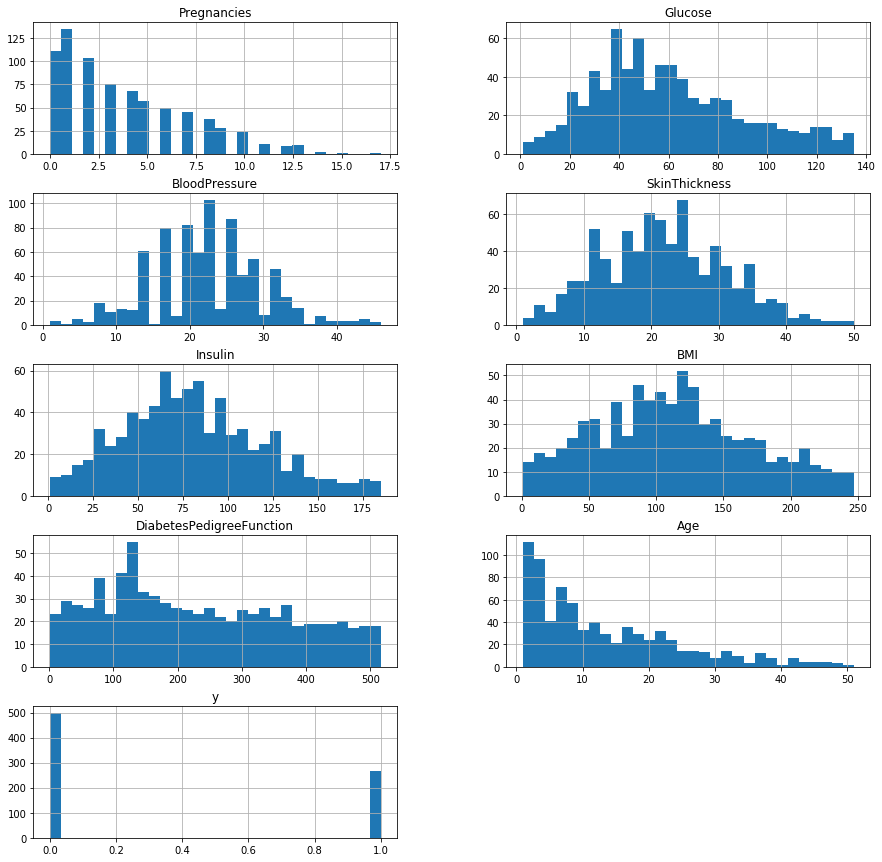

In [116]:
data.hist(bins=30, layout=(5, 2), figsize=(15,15))
plt.show()

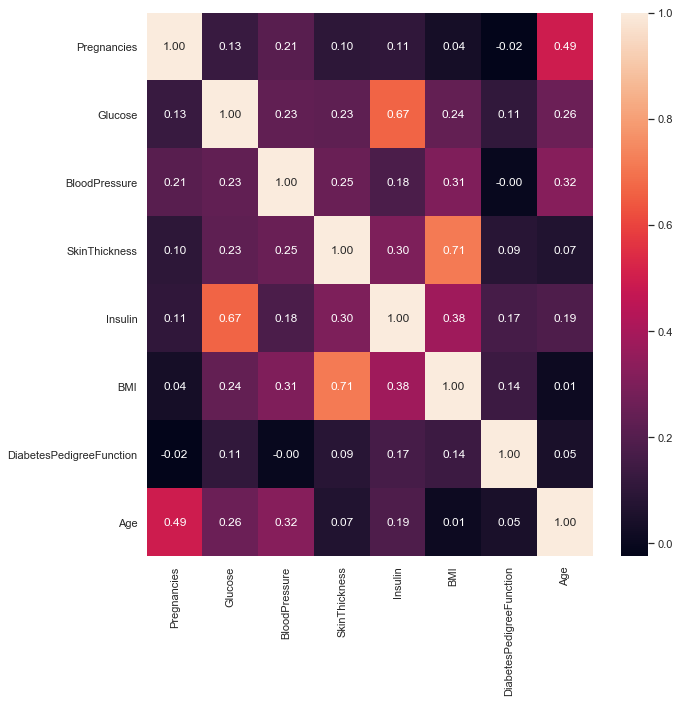

In [117]:
#variance covariance matrix

sns.set(rc = {'figure.figsize':(10,10)})
sns.heatmap(data.drop('y', axis=1).corr(), annot=True, fmt='.2f')

### Class Proportions and the inverse

In [5]:
proportion = sum(data['y'] == 1) / (sum(data['y'] == 1) + sum(data['y'] == 0))
print(proportion)
print(1/proportion)

0.3489583333333333
2.865671641791045


### Build models with different tradeoffs/costs
Build models and save results as a dataframe

In [ ]:
majorCost = 1
minorCost = 1
Costs = [1, 2, 1/proportion, 5, 10, 20, 50, 100]
# Instantiate the models
weights = {0:majorCost, 1:minorCost}
result_table_diabetes = pd.DataFrame(columns=['classifiers', 'costRatio', \
                                     'fpr','tpr', 'thresholds','auc', 'predictions'])

start = time.time()
for cost in Costs:
    minorCost = cost
    random.seed(10)
    #initiate the models
    weights = {0:1, 1:cost}
    model1 = LogisticRegression(solver='lbfgs', class_weight=weights, max_iter = 500)
    model2 = DecisionTreeClassifier(class_weight=weights)
    model3 = XGBClassifier(scale_pos_weight=minorCost/majorCost, use_label_encoder=False)
    model4 = RandomForestClassifier(n_estimators=100, class_weight=weights)
    model5 = SVC(gamma='scale', class_weight=weights, probability = True)
#     
    cv = RepeatedKFold(n_splits=10, n_repeats=3, random_state=10)

    # Train the models and record the results
    for i, model in enumerate(['custom', model1, model2, model3, model4, model5]):
        
        model_name_list = ['Linear Regression', 'Logistic Regression', 'Decision Trees',
                          'xgBoost', "Random Forest", "SVM"]
        
        tprs = []
        fprs = np.linspace(0, 1, 101)
        predictions = []
        thresholds = []
        aucs = []
        
        print(model_name_list[i])
        if(model_name_list[i] == 'Linear Regression'):
            train_features, test_features, train_labels, test_labels = train_test_split(Xs, Y, test_size = 0.1)
            modelEval = CustomLinearModel(lossFunction, Xs, Y, majorCost = majorCost, minorCost = minorCost)
            modelEval.setTrainingTest(train_features, test_features, train_labels, test_labels)
            modelEval.fit()
            test_labels = modelEval.y_test
            predictions = modelEval.predicted
            test_labels = np.array(test_labels).reshape(len(test_labels),)
            predictions = np.array(predictions).reshape(len(predictions),)
            
            aucs = metrics.roc_auc_score(test_labels, predictions)
            fpr, tprs, thresholds = metrics.roc_curve(test_labels, predictions)
            
            #interpolations
            thresholds = np.interp(fprs, tprs, thresholds) #interpolate thresholds from tprs
            tprs = np.interp(fprs, fpr, tprs)

        else:
            
            idx = np.arange(0, len(Y))

            for k, (train, test) in enumerate(cv.split(Xs, Y)):
                y_scores = []
                #fit, predict, and get metrics from the model
                model.fit(Xs[idx][train], Y[idx][train])
                y_score = model.predict_proba(Xs[idx][test])
                fpr, tpr, threshold_ = metrics.roc_curve(Y[idx][test], y_score[:, 1])
                auc = metrics.roc_auc_score(Y[idx][test], y_score[:, 1])
                
                #interpolations
                threshold_ = np.interp(fprs, tpr, threshold_) #interpolate thresholds from tprs
                tpr = np.interp(fprs, fpr, tpr)
                
                #append results to array
                tpr[0] = 0.0
                tprs.append(tpr)
                y_scores.append(y_score[:, 1])
                thresholds.append(threshold_)
                aucs.append(auc)
            tprs = np.array(tprs)
            tprs = tprs.mean(axis=0)
            predictions = np.array(y_scores)
            predictions = predictions.mean(axis=0)
            thresholds = np.array(thresholds)
            thresholds = thresholds.mean(axis=0)
            aucs = np.array(aucs)
            aucs = aucs.mean(axis=0)
            std = tprs.std(axis=0)
            
        result_table_diabetes = result_table_diabetes.append({'classifiers':model_name_list[i],
                                            'costRatio': cost,
                                            'fpr':np.round(fprs, 3), 
                                            'tpr':np.round(tprs, 3), 
                                            'thresholds':np.round(thresholds, 3),
                                            'auc':np.round(aucs, 3),
                                            'predictions': np.round(predictions, 3)
                                           }, ignore_index=True)
        
end = time.time()
print("Took: ", end-start, " seconds.")

### Save output

In [ ]:
# with open("data/Datasets/Diabetes/diabetesModelResults1124.json", "w") as outputfile:
#     outputfile.write(result_table_diabetes.to_json())
# result_table_diabetes

### ROC Curves

Comparison across models

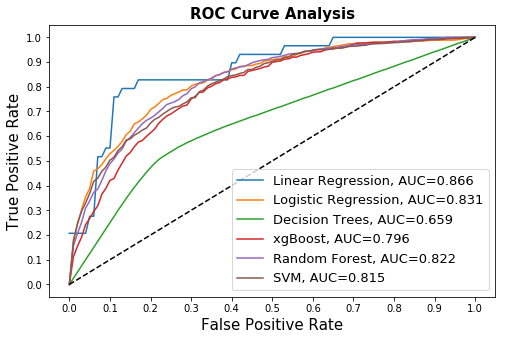

In [67]:
tablesubset = result_table_diabetes[(result_table_diabetes['costRatio'] == 1)]
# Set name of the classifiers as index labels
tablesubset.set_index('classifiers', inplace=True)
fig = plt.figure(figsize=(8,5))
for i in tablesubset.index:
    plt.plot(tablesubset.loc[i]['fpr'], 
             tablesubset.loc[i]['tpr'], 
             label="{}, AUC={:.3f}".format(i, tablesubset.loc[i]['auc']))
plt.plot([0,1], [0,1], color='black', linestyle='--')
plt.xticks(np.arange(0.0, 1.1, step=0.1))
plt.xlabel("False Positive Rate", fontsize=15)
plt.yticks(np.arange(0.0, 1.1, step=0.1))
plt.ylabel("True Positive Rate", fontsize=15)
plt.title('ROC Curve Analysis', fontweight='bold', fontsize=15)
plt.legend(prop={'size':13}, loc='lower right')
plt.show()

### Compare ROC Curves within each type of model

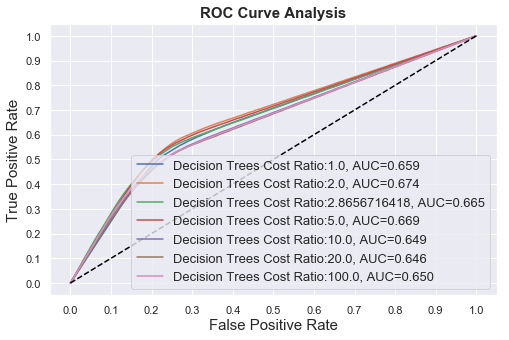

In [160]:
ci = 2
model_name_list = ['Linear Regression', 'Logistic Regression', 'Decision Trees',
                          'xgBoost', "Random Forest", "SVM"]
tablesubset = result_table_diabetes[(result_table_diabetes['classifiers'] == model_name_list[ci])]
# Set name of the classifiers as index labels
tablesubset.set_index('costRatio', inplace=True)
fig = plt.figure(figsize=(8,5))
for i in tablesubset.index:
    plt.plot(tablesubset.loc[i]['fpr'], 
             tablesubset.loc[i]['tpr'], 
             label= model_name_list[ci] + " Cost Ratio:" + "{}, AUC={:.3f}".format(i, tablesubset.loc[i]['auc']))
plt.plot([0,1], [0,1], color='black', linestyle='--')
plt.xticks(np.arange(0.0, 1.1, step=0.1))
plt.xlabel("False Positive Rate", fontsize=15)
plt.yticks(np.arange(0.0, 1.1, step=0.1))
plt.ylabel("True Positive Rate", fontsize=15)
plt.title('ROC Curve Analysis', fontweight='bold', fontsize=15)
plt.legend(prop={'size':13}, loc='lower right')
plt.show()

### Calibration Curves

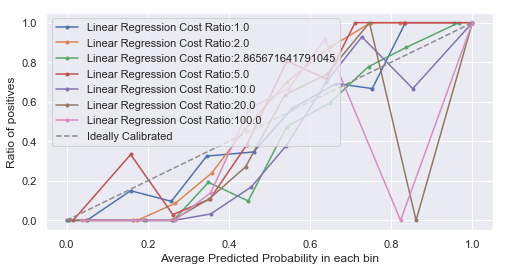

In [63]:
ci = 0
tablesubset = result_table_diabetes[(result_table_diabetes['classifiers'] == model_name_list[ci])]
tablesubset.set_index('costRatio', inplace=True)
# Calibration
fig = plt.figure(figsize=(8,4))
for i in tablesubset.index:
    predictedValue, trueValue = calibration_curve(tablesubset.loc[i]['true'], tablesubset.loc[i]['predictions'], \
                         n_bins = 10, normalize = True)
    plt.plot(trueValue, predictedValue, marker = '.', label = model_name_list[ci] + " Cost Ratio:" + str(i))

plt.plot([0, 1], [0, 1], linestyle = '--', label = 'Ideally Calibrated')
leg = plt.legend(loc = 'upper left')
plt.xlabel('Average Predicted Probability in each bin')
plt.ylabel('Ratio of positives')
plt.show()

In [ ]:
result_table_diabetes = pd.read_json('data/Datasets/Diabetes/diabetesModelResults.json')  
result_table_diabetes


# Applicability Area

### Define parameters

In [5]:
model_name_list = ['Linear Regression', 'Logistic Regression', 'Decision Trees', 'xgBoost', "Random Forest", "SVM"]
# Utilities defined
u = -5
#B
uTP =80 #60, 80
uFN = 0
#H
uTN = 100 + u
uFP = 90

H = uTN - uFP
B = uTP - uFN
utils = [uTN, uTP, uFN, uFP, u]
p = 0.35

### Calculate ApAr and save output

In [13]:
start = time.time()
p = 0.35 #prevalence of diabetes among female Pima Indians: 40%.
#0.1, 0.2*, 0.35*
result_table_diabetes[['applicableArea', 'largestRangePriorThresholdIndex', "withinRange", 'leastViable', "uFP"]] = result_table_diabetes.apply(lambda x:applicableArea(x, x['thresholds'], utils, p), axis = 1, result_type = 'expand')
result_table_diabetes['uTP'] = uTP
result_table_diabetes['prior'] = p 
with open("data/Datasets/Diabetes/uTP801To2Odds1124.json", "w") as outputfile:
    outputfile.write(result_table_diabetes.to_json())
result_table_diabetes

end = time.time()
print("Took: ", end-start, " seconds.")


Took:  286.19526505470276  seconds.


### Read in data

In [22]:
result_table_diabetes = pd.read_json('data/Datasets/Diabetes/uTP801To2Odds1124.json')  
result_table_diabetes = result_table_diabetes[(result_table_diabetes['classifiers'] != model_name_list[0])]
result_table_diabetes = result_table_diabetes.reset_index()
result_table_diabetes

,index,classifiers,costRatio,fpr,tpr,thresholds,auc,predictions,applicableArea,largestRangePriorThresholdIndex,withinRange,leastViable,uFP,uTP,prior
0,1,Logistic Regression,1.000000,"[0.0, 0.01, 0.02, 0.03, 0.04, 0.05, 0.06, 0.07...","[0.0, 0.17500000000000002, 0.23700000000000002...","[1.714, 1.5030000000000001, 1.292, 1.087, 0.96...",0.835,"[0.784, 0.048, 0.32, 0.036000000000000004, 0.3...",0.244,25,True,0.248127,15.000000,80,0.35
1,2,Decision Trees,1.000000,"[0.0, 0.01, 0.02, 0.03, 0.04, 0.05, 0.06, 0.07...","[0.0, 0.026000000000000002, 0.053, 0.079, 0.10...","[2.0, 1.982, 1.964, 1.945, 1.927, 1.909, 1.891...",0.665,"[1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, ...",0.010,22,False,0.383212,15.000000,80,0.35
2,3,xgBoost,1.000000,"[0.0, 0.01, 0.02, 0.03, 0.04, 0.05, 0.06, 0.07...","[0.0, 0.09, 0.131, 0.163, 0.211, 0.246, 0.3000...","[1.763, 1.553, 1.342, 1.138, 1.016, 0.997, 0.9...",0.795,"[0.4880000055, 0.0140000004, 0.5299999714, 0.0...",0.245,25,True,0.296272,15.000000,80,0.35
3,4,Random Forest,1.000000,"[0.0, 0.01, 0.02, 0.03, 0.04, 0.05, 0.06, 0.07...","[0.0, 0.115, 0.192, 0.25, 0.335, 0.368, 0.389,...","[1.6139999999999999, 1.446, 1.279, 1.115, 0.99...",0.822,"[0.5700000000000001, 0.07, 0.30000000000000004...",0.211,30,True,0.269139,15.000000,80,0.35
4,5,SVM,1.000000,"[0.0, 0.01, 0.02, 0.03, 0.04, 0.05, 0.06, 0.07...","[0.0, 0.17300000000000001, 0.224, 0.271, 0.332...","[1.849, 1.596, 1.344, 1.098, 0.940000000000000...",0.824,"[0.461, 0.078, 0.222, 0.047, 0.395, 0.339, 0.1...",0.233,53,True,0.262915,15.000000,80,0.35
5,7,Logistic Regression,2.000000,"[0.0, 0.01, 0.02, 0.03, 0.04, 0.05, 0.06, 0.07...","[0.0, 0.177, 0.24, 0.295, 0.355, 0.385, 0.438,...","[1.7429999999999999, 1.532, 1.322, 1.118, 0.99...",0.835,"[0.883, 0.081, 0.49, 0.063, 0.525, 0.483, 0.46...",0.137,30,True,0.192308,55.000000,80,0.35
6,8,Decision Trees,2.000000,"[0.0, 0.01, 0.02, 0.03, 0.04, 0.05, 0.06, 0.07...","[0.0, 0.027, 0.055, 0.082, 0.11, 0.137, 0.165,...","[2.0, 1.9809999999999999, 1.962, 1.944, 1.925,...",0.668,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, ...",0.000,23,True,0.269934,55.000000,80,0.35
7,9,xgBoost,2.000000,"[0.0, 0.01, 0.02, 0.03, 0.04, 0.05, 0.06, 0.07...","[0.0, 0.085, 0.137, 0.169, 0.223, 0.28, 0.308,...","[1.732, 1.5310000000000001, 1.33, 1.1360000000...",0.793,"[0.6539999843000001, 0.0109999999, 0.612999975...",0.148,32,True,0.221202,55.000000,80,0.35
8,10,Random Forest,2.000000,"[0.0, 0.01, 0.02, 0.03, 0.04, 0.05, 0.06, 0.07...","[0.0, 0.129, 0.191, 0.23900000000000002, 0.294...","[1.775, 1.553, 1.332, 1.116, 0.97, 0.935, 0.91...",0.827,"[0.56, 0.06, 0.42, 0.01, 0.27, 0.4100000000000...",0.147,35,True,0.197173,55.000000,80,0.35
9,11,SVM,2.000000,"[0.0, 0.01, 0.02, 0.03, 0.04, 0.05, 0.06, 0.07...","[0.0, 0.193, 0.263, 0.317, 0.363, 0.383, 0.413...","[1.843, 1.584, 1.325, 1.072, 0.907, 0.874, 0.8...",0.827,"[0.394, 0.045, 0.245, 0.022, 0.5, 0.4, 0.09, 0...",0.152,47,True,0.201674,55.000000,80,0.35


### EDA: compare AUC and ApAr

In [25]:
sorted_auc = result_table_diabetes[(result_table_diabetes['classifiers'] != model_name_list[0])].sort_values(by = ['auc']).tail(10)
# with open("data/Datasets/Diabetes/uTP801To2OddsHBsortedByAuc.csv", "w") as outputfile:
#     outputfile.write(sorted_auc.to_csv())

In [ ]:
sorted_aa = result_table_diabetes[(result_table_diabetes['classifiers'] != model_name_list[0]) & (result_table_diabetes['applicableArea'] > 0) & (result_table_diabetes['largestRangePriorThresholdIndex'] != -999)].sort_values(by=['applicableArea']).tail(10)
# with open("data/Datasets/Diabetes/uTP801To2OddsHBsortedByAA.csv", "w") as outputfile:
#     outputfile.write(sorted_aa.to_csv())
# sorted_aa

### Select a model and evaluate its ApAr

In [34]:
# model_name_list = ['Linear Regression', 'Logistic Regression', 'Decision Trees',
#                                               'xgBoost', "Random Forest", "SVM"]
ci =1
modelTest = result_table_diabetes[(result_table_diabetes['classifiers'] == model_name_list[ci]) & \
                           (result_table_diabetes['costRatio'] == 2)
                          ]
# print(np.array(modelTest['tpr']), np.array(modelTest['fpr']))
modelTest

,classifiers,costRatio,fpr,tpr,thresholds,auc,predictions,applicableArea,largestRangePriorThresholdIndex,withinRange,leastViable,uFP,uTP,prior
7,Logistic Regression,2.0,"[0.0, 0.01, 0.02, 0.03, 0.04, 0.05, 0.06, 0.07...","[0.0, 0.177, 0.24, 0.295, 0.355, 0.385, 0.438,...","[1.7429999999999999, 1.532, 1.322, 1.118, 0.99...",0.835,"[0.883, 0.081, 0.49, 0.063, 0.525, 0.483, 0.46...",0.137,30,True,0.192308,55.0,80,0.35


### Graph ApAr

Text(0, 0.5, 'Prior')

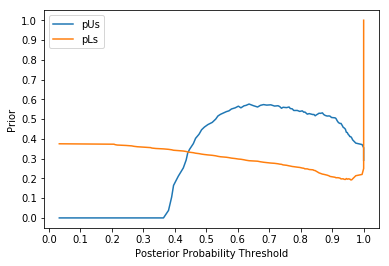

In [35]:
#calculate pLs, pStars, and pUs
# pLs, pStars, pUs, allPriors = modelPriorsOverRocWithAllPriors(modelTest, uTN, uTP, uFN,modelTest['uFP'], u)
pLs, pStars, pUs = modelPriorsOverRoc(modelTest, uTN, uTP, uFN, modelTest['uFP'], u)
thresholds = np.array(modelTest['thresholds'])[0]
thresholds = np.array(thresholds)
thresholds = np.where(thresholds > 1, 1, thresholds)
thresholds, pLs, pUs = adjustpLpUClassificationThreshold(thresholds, pLs, pUs)
plt.plot(thresholds, pUs, label = "pUs")
plt.plot(thresholds, pLs, label = "pLs")
plt.xticks(np.arange(0.0, 1.1, step=0.1))
plt.yticks(np.arange(0.0, 1.1, step=0.1))

# plt.plot(1-thresholds, pUs, label = "pUs")
# plt.plot(1-thresholds, pLs, label = "pLs")
plt.legend()
plt.xlabel("ROC Cutoff Threshold")
plt.ylabel("Prior")

### Calculate the area

In [25]:
modelTest.apply(lambda x:applicablePriorDistribution(x, x['thresholds'], [uTN, uTP, uFN, modelTest['uFP'], u], p), axis = 1, result_type = 'expand')

,0,1,2,3
3,0.111,38,True,65


### Select another model or change the parameters

Text(0, 0.5, 'Prior')

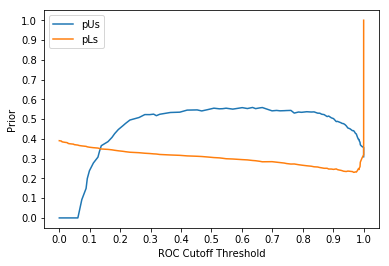

In [179]:
#calculate pLs, pStars, and pUs
# pLs, pStars, pUs, allPriors = modelPriorsOverRocWithAllPriors(modelTest, uTN, uTP, uFN,modelTest['uFP'], u)
pLs, pStars, pUs = modelPriorsOverRoc(modelTest, uTN, uTP, uFN, modelTest['uFP'], u)
thresholds = np.array(modelTest['thresholds'])[0]
thresholds = np.array(thresholds)
thresholds = np.where(thresholds > 1, 1, thresholds)
thresholds, pLs, pUs = adjustpLpUClassificationThreshold(thresholds, pLs, pUs)
plt.plot(thresholds, pUs, label = "pUs")
plt.plot(thresholds, pLs, label = "pLs")
plt.xticks(np.arange(0.0, 1.1, step=0.1))
plt.yticks(np.arange(0.0, 1.1, step=0.1))

# plt.plot(1-thresholds, pUs, label = "pUs")
# plt.plot(1-thresholds, pLs, label = "pLs")
plt.legend()
plt.xlabel("ROC Cutoff Threshold")
plt.ylabel("Prior")

In [ ]:
sensitivity = 1
specificity = 1 - 0.28
print(p, sensitivity, specificity)
expectedGainUtil(sensitivity, specificity, uTN, uTP, uFN, 94.25, u, graph = True)

### Graph expected utility curves

In [ ]:
sensitivity = 1
specificity = 1 - 0.28
# print(modelTprs[10])
# print(1-modelFprs[10])
# sensitivity = modelTprs[10]
# specificity = 1-modelFprs[10]
print(p, sensitivity, specificity)
expectedGainUtil(sensitivity, specificity, uTN, uTP, uFN, 94.25, u, graph = True)